In [2]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../scripts')))
# from utils import missing_values_table, fix_outlier, convert_bytes_to_megabytes, convert_ms_to_seconds
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


### calling load_data_from_postgres function 

In [ ]:

from load_data import load_data_from_postgres

In [5]:
query = "SELECT * FROM xdr_data"

In [7]:
df_postgres = load_data_from_postgres(query)
print("Data loaded using psycopg2:")

Data loaded using psycopg2:


### filtering columns that are needed for user experience analysis

In [8]:
user_experience_columns = [
    'IMSI',
    'Handset Type',
    'Avg RTT DL (ms)',
    'Avg RTT UL (ms)',
    'Avg Bearer TP DL (kbps)',
    'Avg Bearer TP UL (kbps)',
    'TCP DL Retrans. Vol (Bytes)',
    'TCP UL Retrans. Vol (Bytes)'
]


In [9]:
# Create the df_user_experience DataFrame with the selected columns
df_user_experience = df_postgres[user_experience_columns].copy()

### EDA on the extracted data

In [10]:
df_user_experience.head()

,IMSI,Handset Type,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes)
0,2.082014e+14,Samsung Galaxy A5 Sm-A520F,42.0,5.0,23.0,44.0,NaN,NaN
1,2.082019e+14,Samsung Galaxy J5 (Sm-J530),65.0,5.0,16.0,26.0,NaN,NaN
2,2.082003e+14,Samsung Galaxy A8 (2018),NaN,NaN,6.0,9.0,NaN,NaN
3,2.082014e+14,undefined,NaN,NaN,44.0,44.0,NaN,NaN
4,2.082014e+14,Samsung Sm-G390F,NaN,NaN,6.0,9.0,NaN,NaN


In [11]:
df_user_experience.shape

(150001, 8)

In [12]:
df_user_experience.info

<bound method DataFrame.info of                 IMSI                 Handset Type  Avg RTT DL (ms)  \
0       2.082014e+14   Samsung Galaxy A5 Sm-A520F             42.0   
1       2.082019e+14  Samsung Galaxy J5 (Sm-J530)             65.0   
2       2.082003e+14     Samsung Galaxy A8 (2018)              NaN   
3       2.082014e+14                    undefined              NaN   
4       2.082014e+14             Samsung Sm-G390F              NaN   
...              ...                          ...              ...   
149996  2.082022e+14  Apple iPhone 8 Plus (A1897)             32.0   
149997  2.082019e+14      Apple iPhone Se (A1723)             27.0   
149998  2.082017e+14      Apple iPhone Xs (A2097)             43.0   
149999  2.082021e+14               Huawei Fig-Lx1             37.0   
150000           NaN                         None              NaN   

        Avg RTT UL (ms)  Avg Bearer TP DL (kbps)  Avg Bearer TP UL (kbps)  \
0                   5.0                     23.0  

### checking for missing values using imported function missing_values_table

In [13]:
missing_values_table(df_user_experience)


Your selected dataframe has 8 columns.
There are 8 columns that have missing values.


,Missing Values,% of Total Values
TCP UL Retrans. Vol (Bytes),96649,64.4
TCP DL Retrans. Vol (Bytes),88146,58.8
Avg RTT DL (ms),27829,18.6
Avg RTT UL (ms),27812,18.5
Handset Type,572,0.4
IMSI,570,0.4
Avg Bearer TP DL (kbps),1,0.0
Avg Bearer TP UL (kbps),1,0.0


## cleaning the data by using different techniques 

In [15]:
df_user_experience.dropna(subset=['IMSI'], inplace=True)
df_user_experience.dropna(subset=['Handset Type'], inplace=True)
missing_values_table(df_user_experience)


Your selected dataframe has 8 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
TCP UL Retrans. Vol (Bytes),96432,64.5
TCP DL Retrans. Vol (Bytes),87937,58.8
Avg RTT DL (ms),27693,18.5
Avg RTT UL (ms),27675,18.5


### Filling the missing Values of the above fields with the mean of the respective columns

In [16]:
# Calculate mean values
mean_rtt_dl = df_user_experience['TCP UL Retrans. Vol (Bytes)'].mean()
mean_rtt_ul = df_user_experience['TCP DL Retrans. Vol (Bytes)'].mean()
mean_rtt_dl = df_user_experience['Avg RTT UL (ms)'].mean()
mean_rtt_ul = df_user_experience['Avg RTT DL (ms)'].mean()

# Fill missing values with mean
df_user_experience['Avg RTT DL (ms)'].fillna(mean_rtt_dl, inplace=True)
df_user_experience['Avg RTT UL (ms)'].fillna(mean_rtt_ul, inplace=True)
df_user_experience['TCP UL Retrans. Vol (Bytes)'].fillna(mean_rtt_dl, inplace=True)
df_user_experience['TCP DL Retrans. Vol (Bytes)'].fillna(mean_rtt_ul, inplace=True)

In [17]:
missing_values_table(df_user_experience)

Your selected dataframe has 8 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


## fixing outliers 

In [18]:
user_experience_columns_to_apply_quartiles = ['Avg RTT DL (ms)',
    'Avg RTT UL (ms)',
    'Avg Bearer TP DL (kbps)',
    'Avg Bearer TP UL (kbps)',
    'TCP DL Retrans. Vol (Bytes)',
    'TCP UL Retrans. Vol (Bytes)']

In [19]:
# Apply the fix_outlier function to each specified column
for column in user_experience_columns_to_apply_quartiles:
    if column in df_user_experience.columns:
        df_user_experience = fix_outlier(df_user_experience, column)

## Formatting the data

### Byte to Megabyte conversion

In [20]:
byte_columns = [
    'TCP DL Retrans. Vol (Bytes)',
    'TCP UL Retrans. Vol (Bytes)']


In [21]:
for column in byte_columns:
    if column in df_user_experience.columns:
        df_user_experience[column] = df_user_experience[column].apply(convert_bytes_to_megabytes)

### converting milliseconds to seconds

In [22]:
millisecond_columns = [
    'Avg RTT DL (ms)',
    'Avg RTT UL (ms)'
]

In [23]:
for column in millisecond_columns:
    if column in df_user_experience.columns:
        df_user_experience[column] = df_user_experience[column].apply(convert_ms_to_seconds)

### renaming the columns

In [24]:
df_user_experience.rename(columns=lambda x: x.replace('Bytes', 'Megabytes') if 'Bytes' in x else x, inplace=True)
df_user_experience.rename(columns=lambda x: x.replace('(ms)', '(s)') if '(ms)' in x else x, inplace=True)

In [25]:
df_user_experience.head()

,IMSI,Handset Type,Avg RTT DL (s),Avg RTT UL (s),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Megabytes),TCP UL Retrans. Vol (Megabytes)
0,2.082014e+14,Samsung Galaxy A5 Sm-A520F,0.042000,0.00500,23.0,44.0,0.000103,0.000017
1,2.082019e+14,Samsung Galaxy J5 (Sm-J530),0.065000,0.00500,16.0,26.0,0.000103,0.000017
2,2.082003e+14,Samsung Galaxy A8 (2018),0.017675,0.10811,11.0,18.0,0.000103,0.000017
3,2.082014e+14,undefined,0.017675,0.10811,44.0,44.0,0.000103,0.000017
4,2.082014e+14,Samsung Sm-G390F,0.017675,0.10811,11.0,18.0,0.000103,0.000017


## Computing & list 10 of the top, bottom, and most frequent values for some columns

In [34]:
df_user_experience['Total TCP Retransmission'] = df_user_experience['TCP DL Retrans. Vol (Megabytes)'] + df_user_experience['TCP UL Retrans. Vol (Megabytes)']
df_user_experience['Total RTT'] = df_user_experience['Avg RTT DL (s)'] + df_user_experience['Avg RTT UL (s)']
df_user_experience['Total Throughput'] = df_user_experience['Avg Bearer TP DL (kbps)'] + df_user_experience['Avg Bearer TP UL (kbps)']


### top, bottom, and most frequent values of TCP Retransmission

In [36]:
top_10_tcp = df_user_experience['Total TCP Retransmission'].nlargest(10)
# Bottom 10 TCP Values
bottom_10_tcp = df_user_experience['Total TCP Retransmission'].nsmallest(10)
# Most Frequent TCP Values
most_frequent_tcp = df_user_experience['Total TCP Retransmission'].value_counts().head(10)

In [39]:
print("Top 10 TCP Retransmission Values:\n", top_10_tcp)
print("Bottom 10 TCP Retransmission Values:\n", bottom_10_tcp)
print("Most Frequent TCP Retransmission Values:\n", most_frequent_tcp)

Top 10 TCP Retransmission Values:
 15     11.862903
82     11.862903
154    11.862903
155    11.862903
216    11.862903
331    11.862903
539    11.862903
555    11.862903
566    11.862903
591    11.862903
Name: Total TCP Retransmission, dtype: float64
Bottom 10 TCP Retransmission Values:
 0     0.00012
1     0.00012
2     0.00012
3     0.00012
4     0.00012
5     0.00012
6     0.00012
8     0.00012
10    0.00012
12    0.00012
Name: Total TCP Retransmission, dtype: float64
Most Frequent TCP Retransmission Values:
 0.000120     85699
11.862903     2960
0.001337       650
0.001371       270
0.001285       248
0.001360       149
11.672850      140
0.002554       120
0.002640       112
0.001274       105
Name: Total TCP Retransmission, dtype: int64


### top, bottom, and most frequent values of RTT Values

In [40]:
# Top 10 RTT Values
top_10_rtt = df_user_experience['Total RTT'].nlargest(10)
# Bottom 10 RTT Values
bottom_10_rtt = df_user_experience['Total RTT'].nsmallest(10)
# Most Frequent RTT Values
most_frequent_rtt = df_user_experience['Total RTT'].value_counts().head(10)

In [41]:
print("\nTop 10 RTT Values:\n", top_10_rtt)
print("Bottom 10 RTT Values:\n", bottom_10_rtt)
print("Most Frequent RTT Values:\n", most_frequent_rtt)


Top 10 RTT Values:
 535     0.33211
667     0.33211
1092    0.33211
1752    0.33211
1843    0.33211
1916    0.33211
2072    0.33211
2696    0.33211
3229    0.33211
3253    0.33211
Name: Total RTT, dtype: float64
Bottom 10 RTT Values:
 148     0.018675
289     0.018675
383     0.018675
401     0.018675
489     0.018675
732     0.018675
3991    0.018675
3997    0.018675
4144    0.018675
4559    0.018675
Name: Total RTT, dtype: float64
Most Frequent RTT Values:
 0.125786    27685
0.039000     3651
0.029000     2909
0.040000     2431
0.029000     2056
0.038000     2047
0.031000     1991
0.028000     1644
0.047000     1572
0.032000     1549
Name: Total RTT, dtype: int64


### top, bottom, and most frequent values of Throughput Values

In [43]:
# Top 10 Throughput Values
top_10_throughput = df_user_experience['Total Throughput'].nlargest(10)
# Bottom 10 Throughput Values
bottom_10_throughput = df_user_experience['Total Throughput'].nsmallest(10)
# Most Frequent Throughput Values
most_frequent_throughput = df_user_experience['Total Throughput'].value_counts().head(10)

In [44]:
print("\nTop 10 Throughput Values:\n", top_10_throughput)
print("Bottom 10 Throughput Values:\n", bottom_10_throughput)
print("Most Frequent Throughput Values:\n", most_frequent_throughput)


Top 10 Throughput Values:
 170    73170.8
317    73170.8
331    73170.8
454    73170.8
557    73170.8
572    73170.8
624    73170.8
628    73170.8
634    73170.8
667    73170.8
Name: Total Throughput, dtype: float64
Bottom 10 Throughput Values:
 2     29.0
4     29.0
10    29.0
13    29.0
19    29.0
23    29.0
27    29.0
35    29.0
37    29.0
42    29.0
Name: Total Throughput, dtype: float64
Most Frequent Throughput Values:
 29.0       5607
63.0       3853
73170.8    2317
97.0       1955
90.0       1884
98.0       1806
96.0       1770
99.0       1574
89.0       1549
91.0       1513
Name: Total Throughput, dtype: int64


### average throughput per handset type

In [45]:
df_user_experience['Avg Throughput'] = (df_user_experience['Avg Bearer TP DL (kbps)'] + df_user_experience['Avg Bearer TP UL (kbps)']) / 2
throughput_per_handset = df_user_experience.groupby('Handset Type')['Avg Throughput'].mean().reset_index()


In [47]:
throughput_per_handset

,Handset Type,Avg Throughput
0,A-Link Telecom I. Cubot A5,11755.000000
1,A-Link Telecom I. Cubot Note Plus,3349.500000
2,A-Link Telecom I. Cubot Note S,4468.500000
3,A-Link Telecom I. Cubot Nova,28108.500000
4,A-Link Telecom I. Cubot Power,31472.400000
...,...,...
1391,Zte Zte Blade C2 Smartphone Android By Sfr Sta...,34.750000
1392,Zyxel Communicat. Lte7460,25154.500000
1393,Zyxel Communicat. Sbg3600,36585.400000
1394,Zyxel Communicat. Zyxel Wah7706,1086.500000


### distribution of average throughput per handset type

In [61]:
# Step 1: Filter out handsets with very few entries
handset_counts = df_user_experience['Handset Type'].value_counts()
filtered_handsets = handset_counts[handset_counts > 50].index  
df_filtered = df_user_experience[df_user_experience['Handset Type'].isin(filtered_handsets)]

In [62]:
df_filtered['Avg Throughput'] = (df_filtered['Avg Bearer TP DL (kbps)'] + df_filtered['Avg Bearer TP UL (kbps)']) / 2
throughput_per_handset = df_filtered.groupby('Handset Type')['Avg Throughput'].mean().sort_values().reset_index()

c:\Telecom-Business-Analyzer\virtual_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


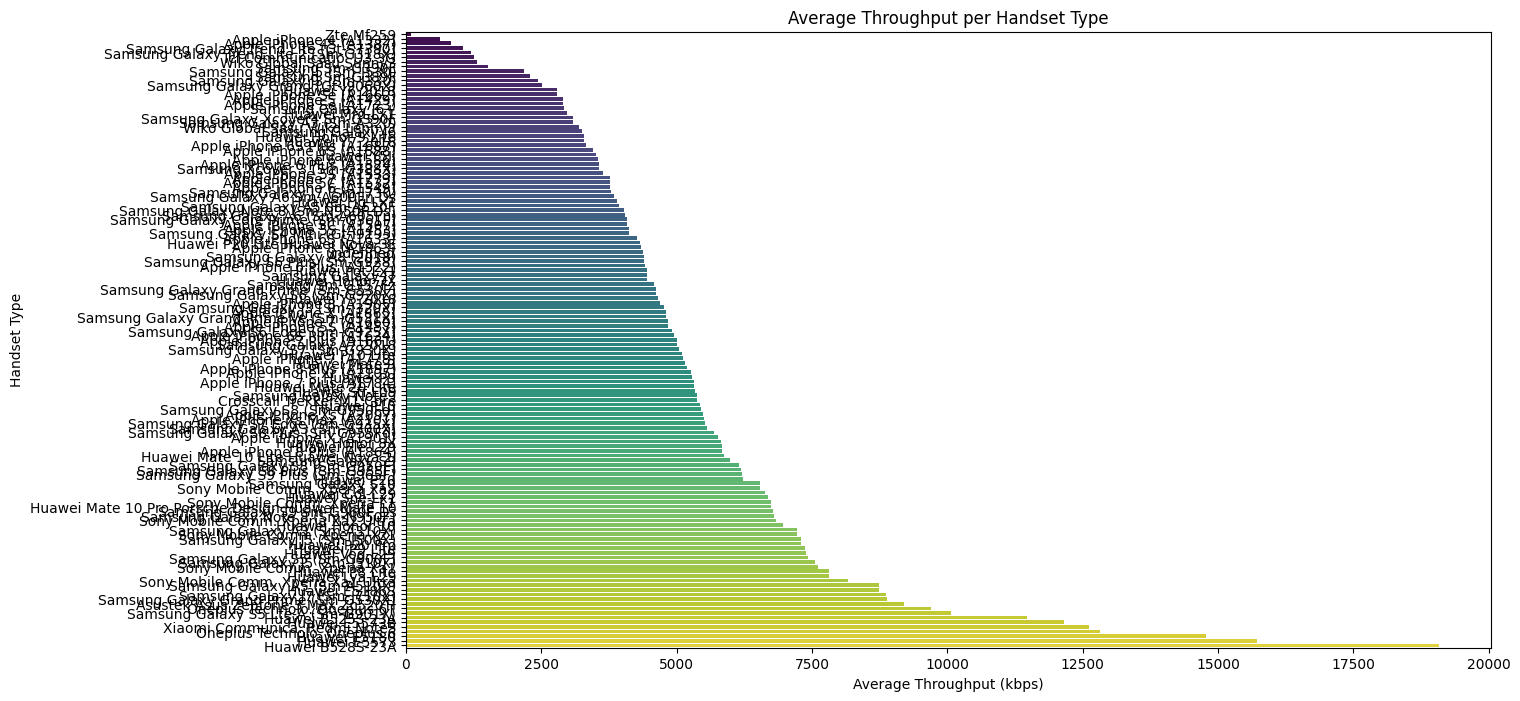

In [63]:
plt.figure(figsize=(14, 8))  # Increase plot size for better readability
sns.barplot(x='Avg Throughput', y='Handset Type', data=throughput_per_handset, palette='viridis')
plt.title('Average Throughput per Handset Type')
plt.xlabel('Average Throughput (kbps)')
plt.ylabel('Handset Type')
plt.show()


### Average TCP retransmission per handset type

In [64]:
df_user_experience['Avg TCP Retransmission'] = (df_user_experience['TCP DL Retrans. Vol (Megabytes)'] + df_user_experience['TCP UL Retrans. Vol (Megabytes)']) / 2
tcp_retrans_per_handset = df_user_experience.groupby('Handset Type')['Avg TCP Retransmission'].mean().reset_index()

In [50]:
tcp_retrans_per_handset

,Handset Type,Avg TCP Retransmission
0,A-Link Telecom I. Cubot A5,0.000060
1,A-Link Telecom I. Cubot Note Plus,0.293833
2,A-Link Telecom I. Cubot Note S,5.868485
3,A-Link Telecom I. Cubot Nova,0.065408
4,A-Link Telecom I. Cubot Power,0.003834
...,...,...
1391,Zte Zte Blade C2 Smartphone Android By Sfr Sta...,0.000668
1392,Zyxel Communicat. Lte7460,5.931451
1393,Zyxel Communicat. Sbg3600,5.931451
1394,Zyxel Communicat. Zyxel Wah7706,0.000064


### average TCP retransmission per handset type

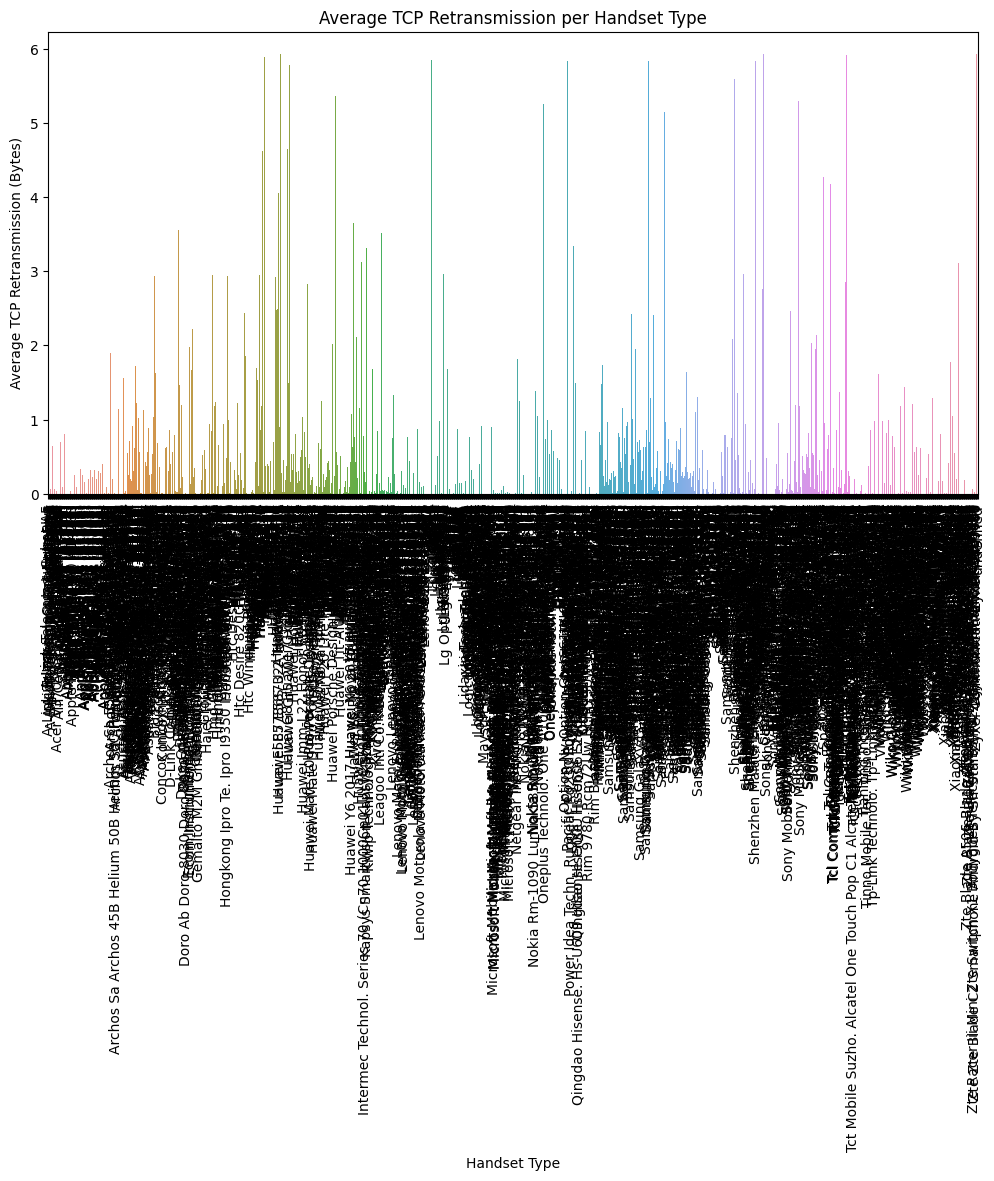

In [65]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Handset Type', y='Avg TCP Retransmission', data=tcp_retrans_per_handset)
plt.xticks(rotation=90)
plt.title('Average TCP Retransmission per Handset Type')
plt.xlabel('Handset Type')
plt.ylabel('Average TCP Retransmission (Bytes)')
plt.show()

## K-Means clustering

In [70]:
# Step 1: Prepare the data for clustering
clustering_data = df_filtered[['Avg TCP Retransmission', 'Avg RTT DL (s)', 'Avg Throughput']].copy()

# Standardizing the data
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)
#Applying K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_filtered['Cluster'] = kmeans.fit_predict(clustering_data_scaled)

c:\Telecom-Business-Analyzer\virtual_env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


In [72]:
cluster_analysis = df_filtered.groupby('Cluster').mean()[['Avg TCP Retransmission', 'Avg RTT DL (s)', 'Avg Throughput']]
cluster_analysis

,Avg TCP Retransmission,Avg RTT DL (s),Avg Throughput
Cluster,,,
0,0.016439,0.033973,910.271037
1,5.252586,0.109230,21839.769708
2,0.617924,0.093846,18695.556394


### Visualization

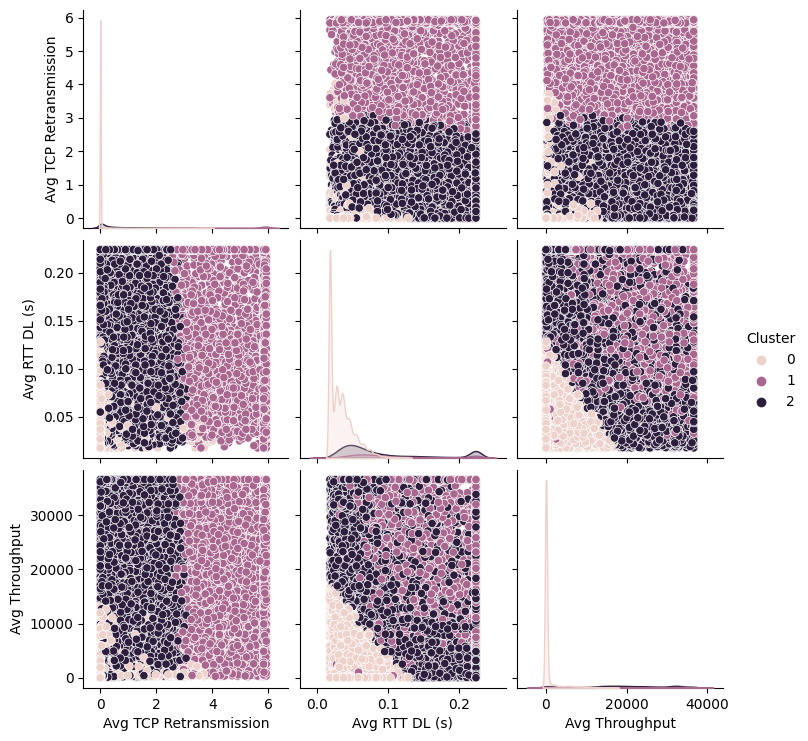

In [74]:
sns.pairplot(df_filtered[['Avg TCP Retransmission', 'Avg RTT DL (s)', 'Avg Throughput', 'Cluster']], hue='Cluster')
plt.show()